--- 2024-01-01 데이터 로딩 시작 ---
[Info] 파일 발견 및 로딩: DOGEUSDT_2024-01-01_1m.parquet
[Info] 파일 발견 및 로딩: 2024-01-01.parquet

   [2024-01-01 결과 보고서]   
최종 자본: $9,939.88
수익률   : -0.60%


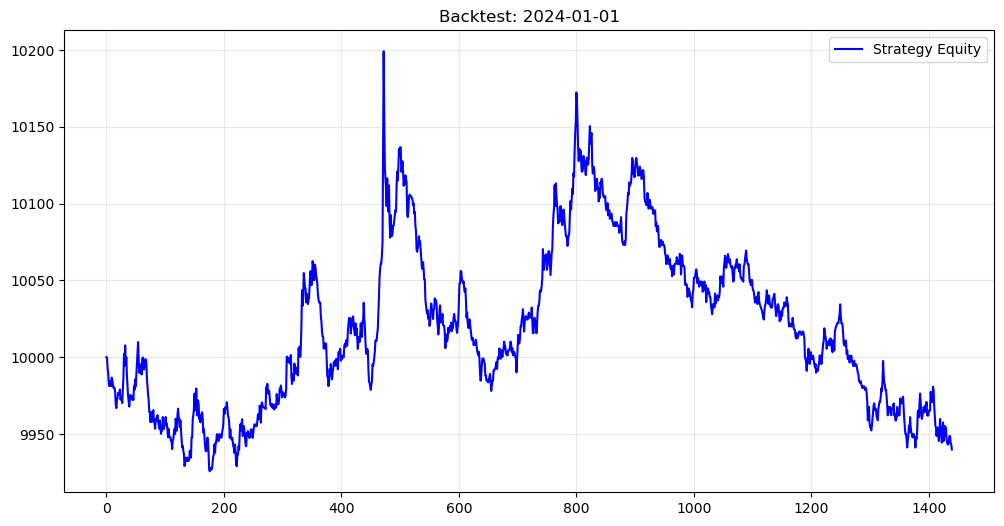

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob  # 파일 검색을 위해 추가

# ==========================================
# 1. 설정: 날짜 및 경로
# ==========================================
TARGET_DATE = "2024-01-01"  # 분석할 날짜

# 경로 확인 (사용자 경로)
BASE_PATH_KLINES = r"C:\Users\elvin\OneDrive - SKKU\Quant\백테스팅 데이터\um_daily\klines\DOGEUSDT\1m"
BASE_PATH_AGG = r"C:\Users\elvin\OneDrive - SKKU\Quant\백테스팅 데이터\um_daily\aggTrades\DOGEUSDT"

COLS_KLINES = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'n_trades', 'taker_buy_base', 'taker_buy_quote', 'ignore']
COLS_AGG = ['agg_trade_id', 'price', 'quantity', 'first_trade_id', 'last_trade_id', 'transact_time', 'is_buyer_maker']

# ==========================================
# 2. 스마트 데이터 로딩 함수 (수정됨)
# ==========================================
def load_data_smart(base_path, target_date, cols, time_col):
    # 1. 파일명에 날짜가 포함된 모든 parquet 파일 검색 (파일명이 달라도 찾음)
    # 예: "2024-01-01.parquet" 또는 "DOGEUSDT-1m-2024-01-01.parquet" 모두 찾음
    search_pattern = os.path.join(base_path, f"*{target_date}*.parquet")
    files = glob.glob(search_pattern)
    
    # 2. 만약 바로 못 찾으면 하위 폴더까지 검색
    if not files:
        search_pattern_recursive = os.path.join(base_path, "**", f"*{target_date}*.parquet")
        files = glob.glob(search_pattern_recursive, recursive=True)
    
    if not files:
        print(f"[Error] '{target_date}' 날짜의 파일을 찾을 수 없습니다.")
        print(f"       경로: {base_path}")
        return None
    
    # 가장 첫 번째로 발견된 파일 로드
    target_file = files[0]
    print(f"[Info] 파일 발견 및 로딩: {os.path.basename(target_file)}")
    
    try:
        df = pd.read_parquet(target_file, engine='pyarrow')
        
        # 컬럼 매핑 (개수가 맞을 때만)
        if len(df.columns) == len(cols):
            df.columns = cols
            
        # 시간 인덱스 설정
        if time_col in df.columns:
            if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
                df['datetime'] = pd.to_datetime(df[time_col], unit='ms')
            else:
                df['datetime'] = df[time_col]
            df.set_index('datetime', inplace=True)
            df.sort_index(inplace=True)
            
        return df
    except Exception as e:
        print(f"[Error] 파일 읽기 실패: {e}")
        return None

# ==========================================
# 3. 데이터 로드 실행
# ==========================================
print(f"--- {TARGET_DATE} 데이터 로딩 시작 ---")

# Klines 로드
df_klines = load_data_smart(BASE_PATH_KLINES, TARGET_DATE, COLS_KLINES, 'open_time')

# AggTrades 로드
df_agg = load_data_smart(BASE_PATH_AGG, TARGET_DATE, COLS_AGG, 'transact_time')

# [중요] 데이터가 하나라도 없으면 여기서 멈춤 (에러 방지)
if df_klines is None or df_agg is None:
    print("\n🛑 데이터 로딩에 실패하여 백테스팅을 중단합니다.")
    print("   위의 [Error] 메시지와 경로를 확인해주세요.")
else:
    # ==========================================
    # 4. 백테스팅 실행 (데이터가 있을 때만 실행됨)
    # ==========================================
    class OneDayBacktester:
        def __init__(self, klines, agg_trades, capital=10000, fee=0.0004):
            # .copy() 에러 방지를 위해 원본 데이터가 있는지 확인
            self.df = klines.copy()
            self.agg = agg_trades.copy()
            self.capital = capital
            self.fee = fee
            
        def run_strategy(self, window=5):
            # AggTrades 가공
            self.agg['taker_buy'] = np.where(~self.agg['is_buyer_maker'], self.agg['quantity'], 0)
            self.agg['taker_sell'] = np.where(self.agg['is_buyer_maker'], self.agg['quantity'], 0)
            
            agg_1m = self.agg.resample('1min').agg({'taker_buy': 'sum', 'taker_sell': 'sum'})
            self.df = self.df.merge(agg_1m, left_index=True, right_index=True, how='left').fillna(0)
            
            # 전략 로직
            buy_ma = self.df['taker_buy'].rolling(window).mean()
            sell_ma = self.df['taker_sell'].rolling(window).mean()
            
            self.df['signal'] = np.where(buy_ma > sell_ma, 1, -1)
            self.df['position'] = self.df['signal'].shift(1) # Look-ahead bias 방지
            
            # 수익률 계산
            self.df['market_ret'] = self.df['close'].pct_change()
            self.df['strategy_ret'] = self.df['position'] * self.df['market_ret']
            self.df['cost'] = self.df['position'].diff().abs() * self.fee
            self.df['net_ret'] = self.df['strategy_ret'] - self.df['cost']
            self.df['equity'] = (1 + self.df['net_ret'].fillna(0)).cumprod() * self.capital
            
            return self.df

        def show_result(self):
            final_equity = self.df['equity'].iloc[-1]
            ret_pct = (final_equity / self.capital - 1) * 100
            
            print("\n" + "="*30)
            print(f"   [{TARGET_DATE} 결과 보고서]   ")
            print("="*30)
            print(f"최종 자본: ${final_equity:,.2f}")
            print(f"수익률   : {ret_pct:.2f}%")
            print("="*30)
            
            plt.figure(figsize=(12, 6))
            plt.plot(self.df.index, self.df['equity'], label='Strategy Equity', color='blue')
            plt.title(f"Backtest: {TARGET_DATE}")
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()

    # 클래스 실행
    bt = OneDayBacktester(df_klines, df_agg)
    bt.run_strategy(window=10)
    bt.show_result()